In [1]:
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

import numpy as np

- [Learn Quantum Computing with Qiskit: Shor’s Algorithm. By Monit Sharma](https://medium.com/@_monitsharma/learn-quantum-computing-with-qiskit-shors-algorithm-971b3f6d8795)
- [An Experimental Study of Shor's Factoring Algorithm on IBM Q.](https://arxiv.org/abs/1903.00768)
"They have factored 12,21 and 35 using something called the Kitaev approach. In Shor's algorithm, you perform the QFT in such a manner that the entire answer is given to you at once. However if you instead have a circuit where bit of the answer is given out one at a time, you can drastically reduce the number of required qubits. For example in this paper the number 15 is factored using only 5 qubits. Actually all experimental implementations of Shor's algorithm have been using the Kitaev approach, as otherwise far too many qubits are needed." [Link](https://quantumcomputing.stackexchange.com/questions/8326/is-it-possible-to-run-a-general-implementation-shors-algorithm-on-a-real-ibm-qu)

<img src="../images/shor.png" alt="Alt text" width="500" height="500">

### 

In [2]:
N = 15 
n = 4

In [3]:
a = 7
N_COUNT = 8

## QFT

<img src="../images/qft.png" alt="Alt text" width="500" height="250">

In [4]:
qft = QuantumCircuit(N_COUNT)

for i in range(N_COUNT-1, -1, -1):
    qft.h(i)
    k = 2
    for j in range(i-1, -1, -1):
        qft.cp(2*np.pi/(2**k), j, i)
        k += 1
#    qft.barrier()
for qubit in range(N_COUNT//2):
    qft.swap(qubit, N_COUNT-qubit-1)

qft_t = qft.inverse()
qft_t_gate = qft_t.to_gate()
qft_t_gate.name = 'QFT_T'

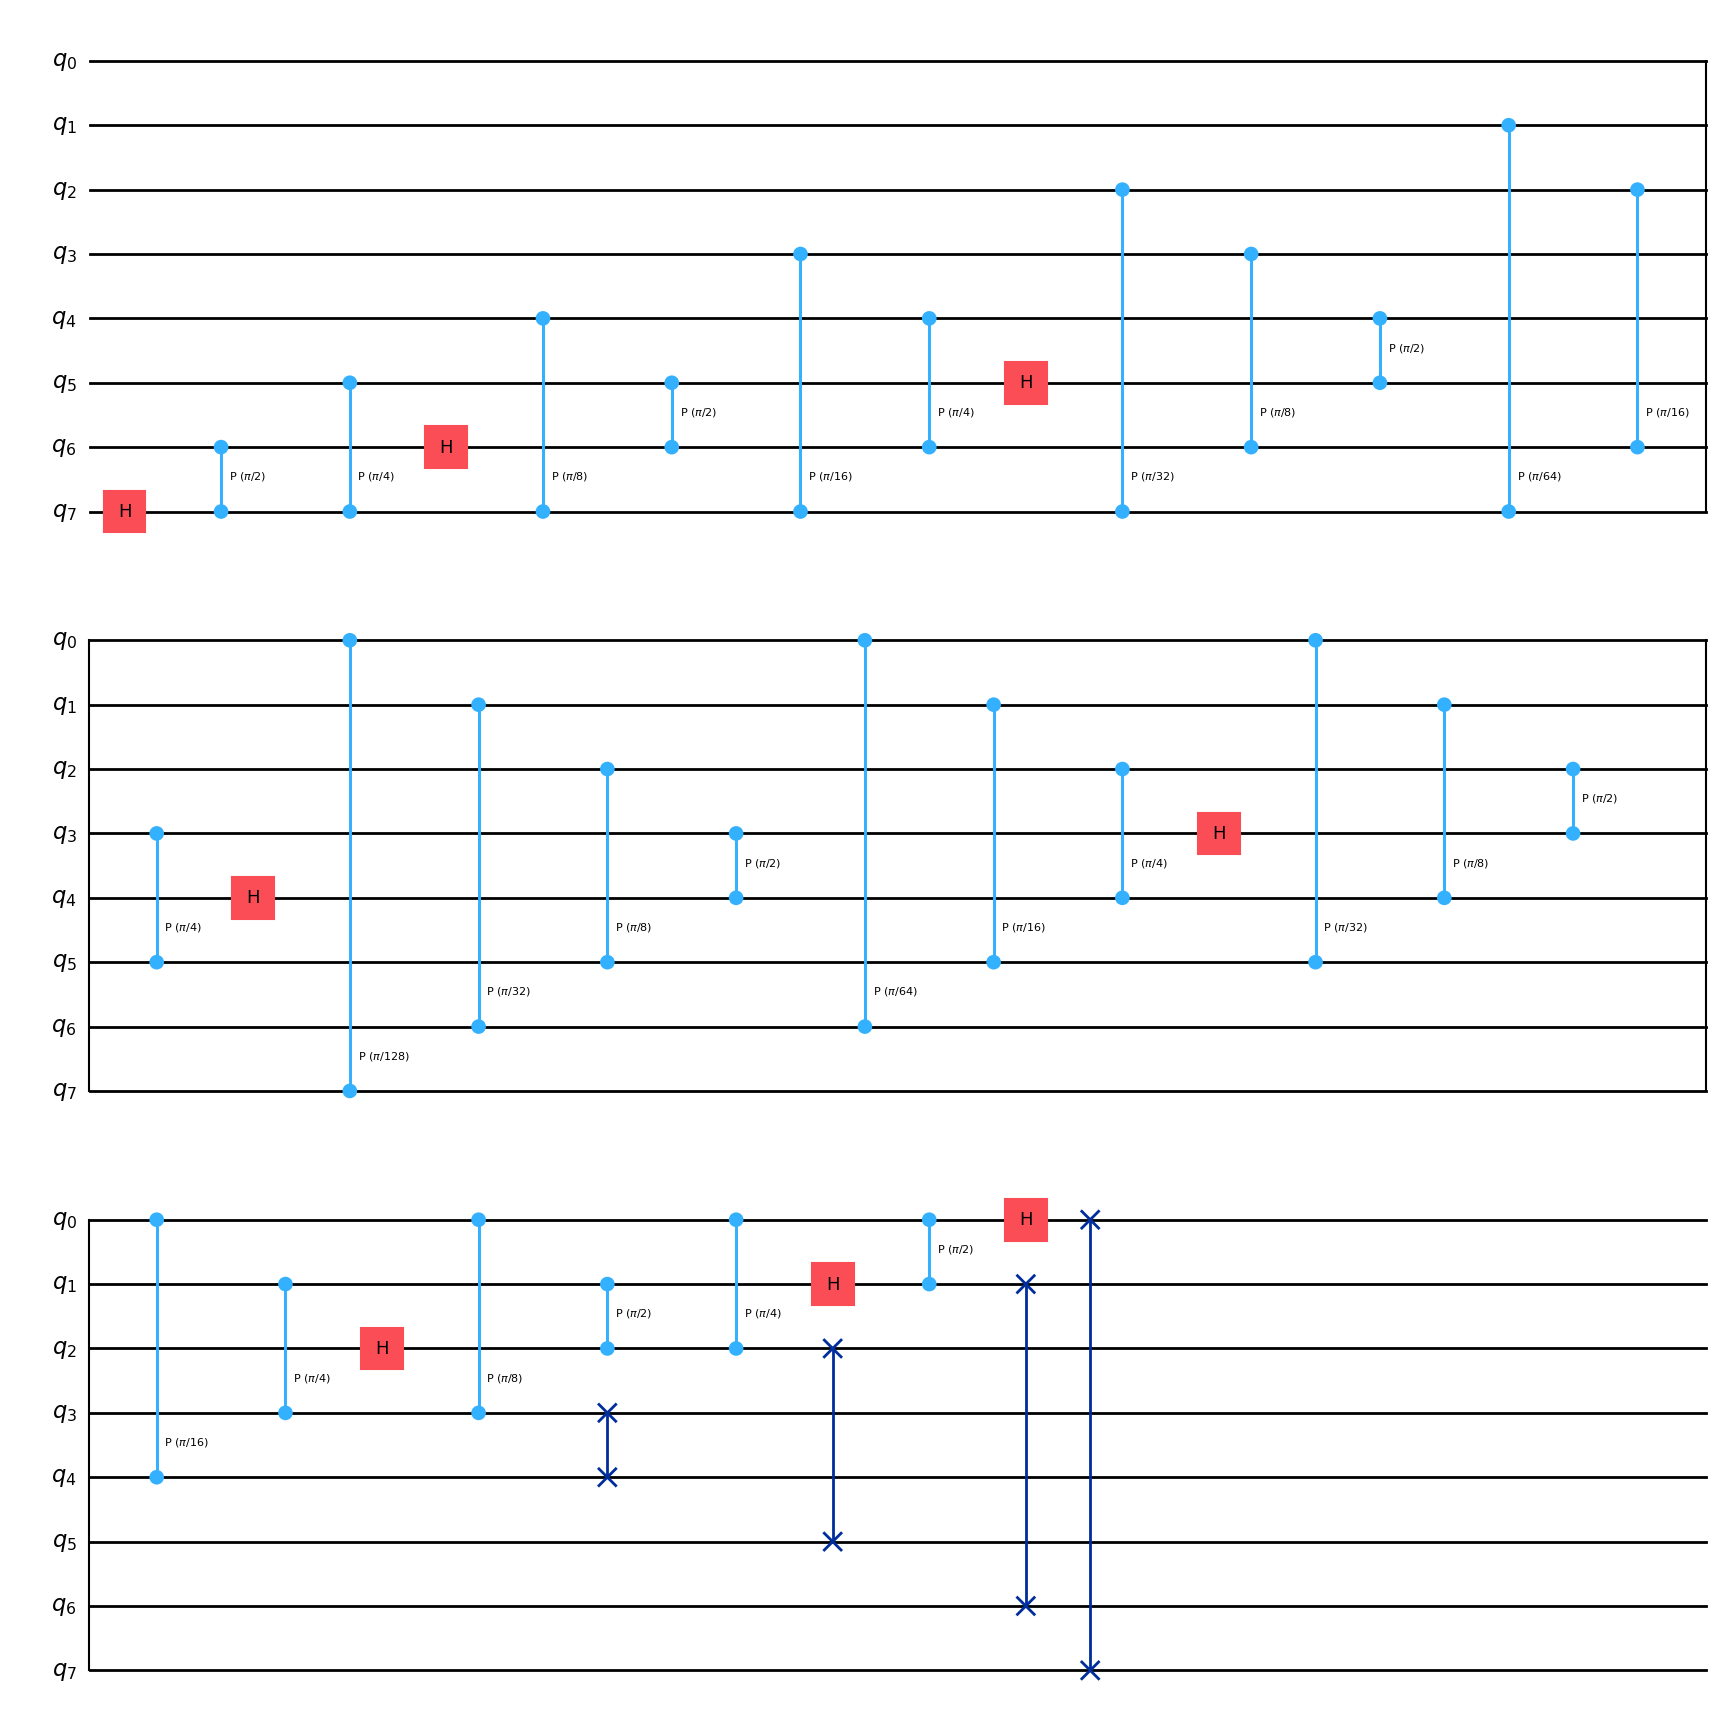

In [5]:
qft.draw("mpl")

## Find the order r

- ***Aula 11***

<img src="../images/qpe.png" alt="Alt text" width="500" height="400">

<img src="../images/u_shor.png" alt="Alt text" width="300" height="100">

In [6]:
from fractions import Fraction

In [7]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    qc = QuantumCircuit(4)
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    for _iteration in range(power):
        if a in [2,13]:
            qc.swap(2,3)
            qc.swap(1,2)
            qc.swap(0,1)
        if a in [7,8]:
            qc.swap(0,1)
            qc.swap(1,2)
            qc.swap(2,3)
        if a in [4, 11]:
            qc.swap(1,3)
            qc.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                qc.x(q)
    U = qc.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

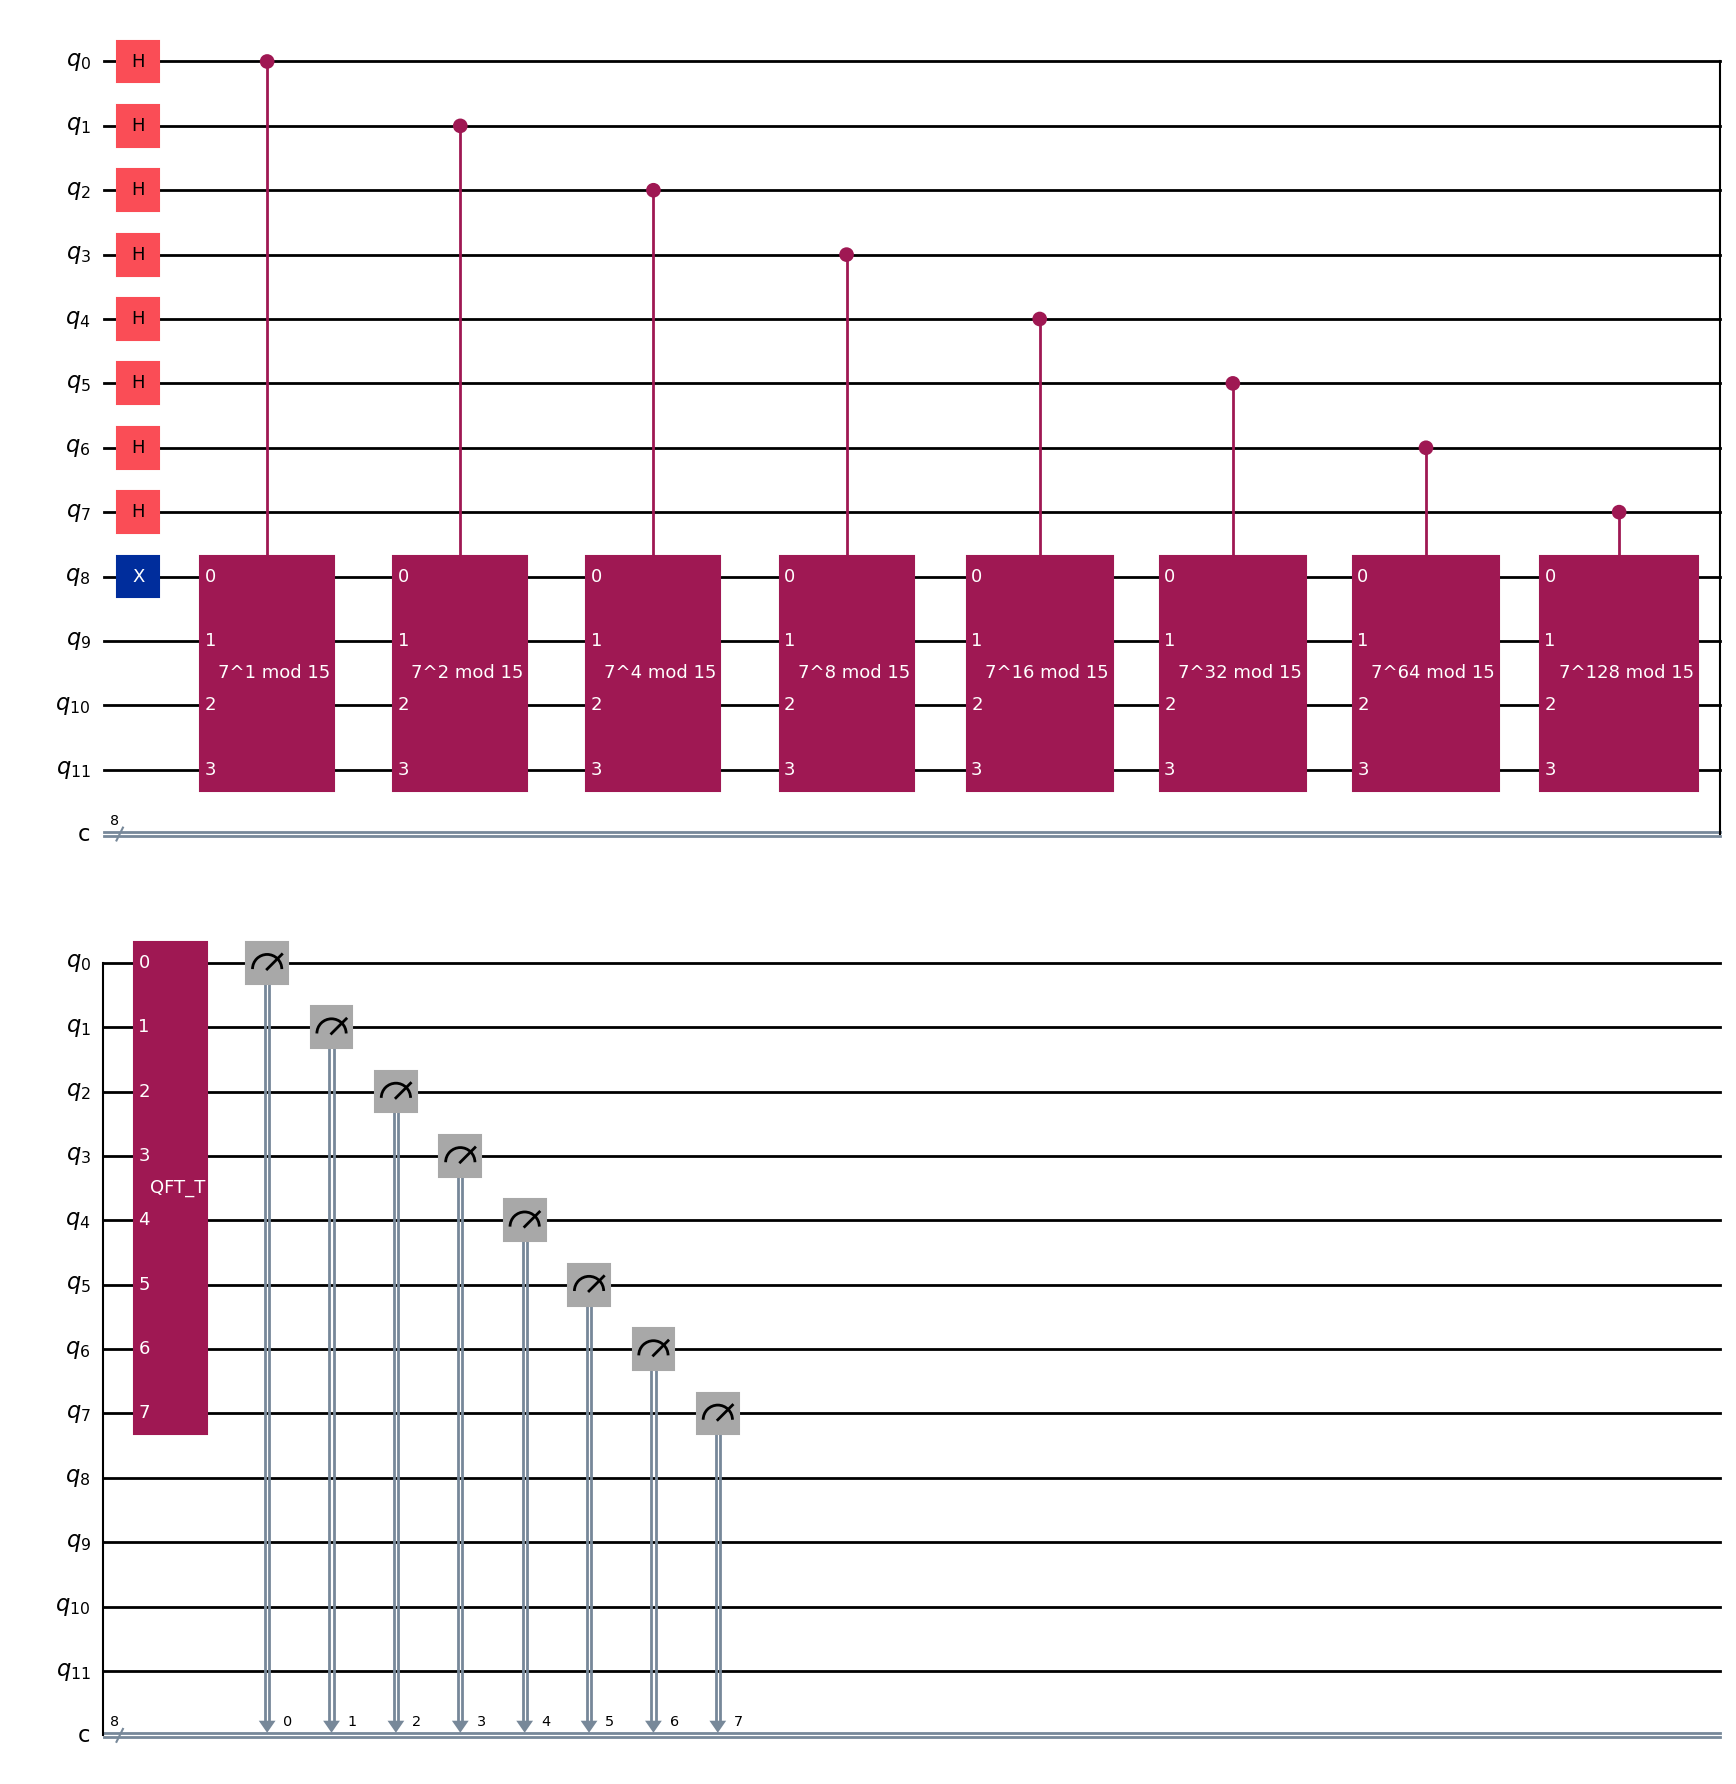

In [12]:
qc = QuantumCircuit(N_COUNT+n, N_COUNT)

qc.h(list(range(N_COUNT)))
qc.x(N_COUNT)

for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q), [q] + [i+N_COUNT for i in range(n)]
              )
    
qc.append(qft_t_gate, range(N_COUNT))

qc.measure(range(N_COUNT), range(N_COUNT))

qc.draw("mpl")

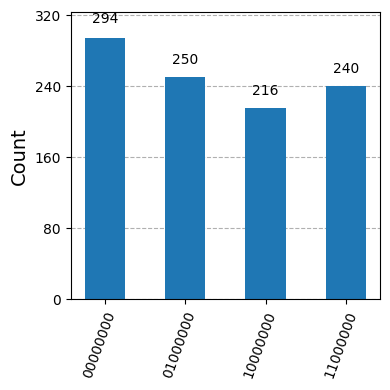

In [13]:
from qiskit.primitives import StatevectorSampler
sampler = StatevectorSampler()
job = sampler.run([qc], shots=1000)
result = job.result()
counts = result[0].data.c.get_counts()
plot_histogram(counts, figsize=(4,4))

In [14]:
data, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    data.append(
                {"Register Output": f"{output}(bin) = {decimal:>3}(dec)",
                 "Phase": f"{decimal}/{2**N_COUNT} = {phase:.2f}"}
               )
data

[{'Register Output': '11000000(bin) = 192(dec)', 'Phase': '192/256 = 0.75'},
 {'Register Output': '01000000(bin) =  64(dec)', 'Phase': '64/256 = 0.25'},
 {'Register Output': '00000000(bin) =   0(dec)', 'Phase': '0/256 = 0.00'},
 {'Register Output': '10000000(bin) = 128(dec)', 'Phase': '128/256 = 0.50'}]

In [15]:
data = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    data.append({"Phase": phase,
                 "Fraction": f"{frac.numerator}/{frac.denominator}",
                 "Guess for r": frac.denominator})
data

[{'Phase': 0.75, 'Fraction': '3/4', 'Guess for r': 4},
 {'Phase': 0.25, 'Fraction': '1/4', 'Guess for r': 4},
 {'Phase': 0.0, 'Fraction': '0/1', 'Guess for r': 1},
 {'Phase': 0.5, 'Fraction': '1/2', 'Guess for r': 2}]